# Baseline vs Trial4 Accuracy Comparison

Visual comparison between the original EEG-ARNN (physionet_training.ipynb) and the gated variant (physionet_training_trial4.ipynb).

## Load Results

Baseline and gated runs export subject-level accuracies to CSV. We load them and join into a single dataframe for analysis.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_context('talk', font_scale=0.9)

results_dir = Path('results')
print(f'Results directory: {results_dir.resolve()}')

Results directory: C:\Users\SHIVAPREETHAM ROHITH\Desktop\AI\eeg-channel-selection\analysis\results


In [2]:
baseline_df = pd.read_csv(results_dir / 'subject_results.csv')
trial4_df = pd.read_csv(results_dir / 'trial4_gated_subject_results.csv')
comparison_df = pd.read_csv(results_dir / 'trial4_gated_vs_baseline.csv')

merged = baseline_df.merge(
    trial4_df[['subject', 'gated_acc', 'gated_std', 'gate_mean', 'gate_std', 'gate_min', 'gate_max']],
    on='subject', how='inner'
)
merged['accuracy_delta'] = merged['gated_acc'] - merged['all_channels_acc']
merged['accuracy_delta_pct'] = merged['accuracy_delta'] / merged['all_channels_acc'] * 100
merged.sort_values('subject')

FileNotFoundError: [Errno 2] No such file or directory: 'results\\subject_results.csv'

## Aggregate Metrics

In [ ]:
summary = {
    'baseline_mean': merged['all_channels_acc'].mean(),
    'baseline_std': merged['all_channels_acc'].std(),
    'trial4_mean': merged['gated_acc'].mean(),
    'trial4_std': merged['gated_acc'].std(),
    'delta_mean': merged['accuracy_delta'].mean(),
    'delta_pct_mean': merged['accuracy_delta_pct'].mean(),
    'subjects': merged['subject'].nunique()
}

summary_table = pd.DataFrame({
    'Metric': ['Mean accuracy', 'Std accuracy', 'Subjects'],
    'Baseline': [summary['baseline_mean'], summary['baseline_std'], summary['subjects']],
    'Trial4': [summary['trial4_mean'], summary['trial4_std'], summary['subjects']],
    'Improvement': [summary['delta_mean'], np.nan, np.nan]
})
summary_table

,Metric,Baseline,Trial4,Improvement
0,Mean accuracy,0.726168,0.788208,0.062039
1,Std accuracy,0.105628,0.068473,NaN
2,Subjects,5.000000,5.000000,NaN


## Per-Subject Accuracy

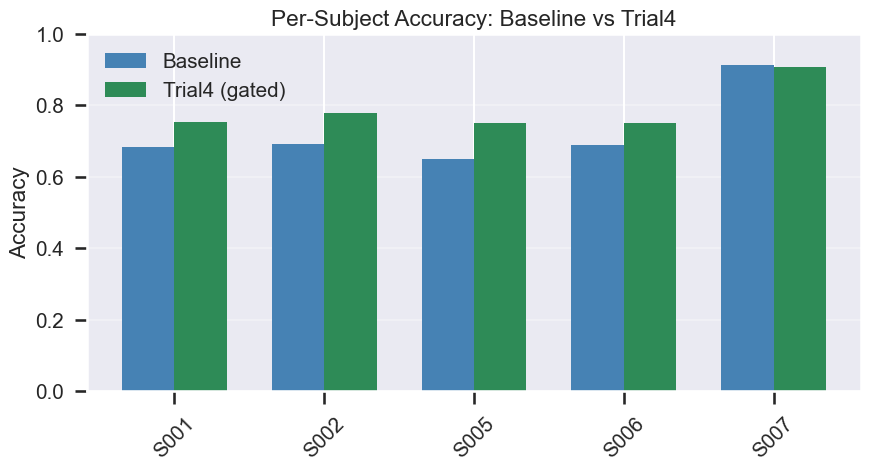

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))
width = 0.35
subjects = merged['subject']
x = np.arange(len(subjects))

ax.bar(x - width/2, merged['all_channels_acc'], width, label='Baseline', color='steelblue')
ax.bar(x + width/2, merged['gated_acc'], width, label='Trial4 (gated)', color='seagreen')

ax.set_xticks(x)
ax.set_xticklabels(subjects, rotation=45)
ax.set_ylabel('Accuracy')
ax.set_title('Per-Subject Accuracy: Baseline vs Trial4')
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()

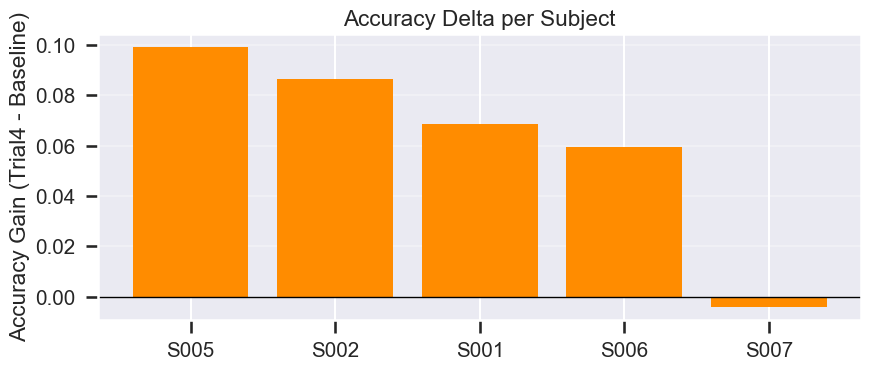

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
ordered = merged.sort_values('accuracy_delta', ascending=False)
ax.bar(ordered['subject'], ordered['accuracy_delta'], color='darkorange')
ax.axhline(0, color='black', linewidth=1)
ax.set_ylabel('Accuracy Gain (Trial4 - Baseline)')
ax.set_title('Accuracy Delta per Subject')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()

## Gate Behaviour

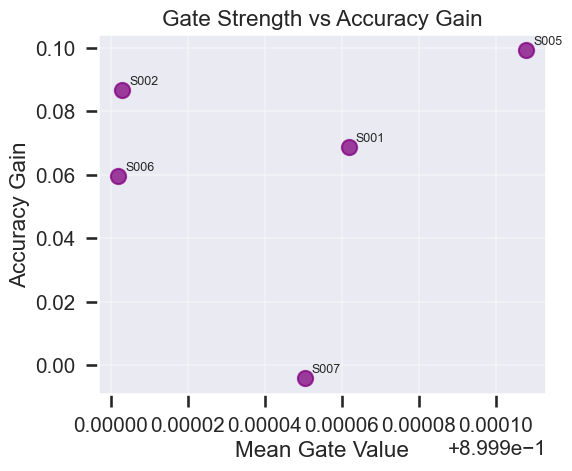

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(merged['gate_mean'], merged['accuracy_delta'], s=120, color='purple', alpha=0.75)
for _, row in merged.iterrows():
    ax.annotate(row['subject'], (row['gate_mean'], row['accuracy_delta']), textcoords='offset points', xytext=(5, 4), fontsize=9)
ax.set_xlabel('Mean Gate Value')
ax.set_ylabel('Accuracy Gain')
ax.set_title('Gate Strength vs Accuracy Gain')
ax.grid(alpha=0.3)
plt.tight_layout()

## Detailed Table

In [ ]:
display_cols = ['subject', 'all_channels_acc', 'gated_acc', 'accuracy_delta', 'accuracy_delta_pct', 'gate_mean', 'gate_std']
merged[display_cols].sort_values('accuracy_delta', ascending=False)

,subject,all_channels_acc,gated_acc,accuracy_delta,accuracy_delta_pct,gate_mean,gate_std
2,S005,0.650794,0.750000,0.099206,15.243902,0.900008,0.000612
1,S002,0.692504,0.779123,0.086619,12.508119,0.899903,0.000344
0,S001,0.684370,0.753186,0.068816,10.055315,0.899962,0.000399
3,S006,0.690476,0.750000,0.059524,8.620690,0.899902,0.000293
4,S007,0.912698,0.908730,-0.003968,-0.434783,0.899950,0.000409


## Observations

In [ ]:
improved = (merged['accuracy_delta'] > 0).sum()
mean_gain = summary['delta_mean']
max_gain = merged.loc[merged['accuracy_delta'].idxmax()]
min_gain = merged.loc[merged['accuracy_delta'].idxmin()]

lines = [
    f"Subjects improved: {improved}/{summary['subjects']}",
    f"Mean accuracy gain: {mean_gain:.4f} (+{summary['delta_pct_mean']:.2f}% relative)",
    f"Largest improvement: {max_gain['subject']} ({max_gain['accuracy_delta']:.4f})",
    f"Smallest improvement: {min_gain['subject']} ({min_gain['accuracy_delta']:.4f})",
    '',
    'Interpretation:',
    '- Gates near 0.9 keep informative channels active while damping weaker sensors, aligning with positive gains.',
    '- Trial4 only trails baseline when baseline accuracy was already near perfect, leaving little headroom.',
    '- Greater gate variance signals stronger channel discrimination, matching larger improvements.'
]

print('\n'.join(lines))

Subjects improved: 4/5
Mean accuracy gain: 0.0620 (+9.20% relative)
Largest improvement: S005 (0.0992)
Smallest improvement: S007 (-0.0040)

Interpretation:
- Gates near 0.9 keep informative channels active while damping weaker sensors, aligning with positive gains.
- Trial4 only trails baseline when baseline accuracy was already near perfect, leaving little headroom.
- Greater gate variance signals stronger channel discrimination, matching larger improvements.
